# [Keras + Universal Sentence Encoder = Transfer Learning for text data](https://www.dlology.com/blog/keras-meets-universal-sentence-encoder-transfer-learning-for-text-data/) Tutorial
## Universal Sentence Encoder

This notebook illustrates how to access the Universal Sentence Encoder and use it for sentence similarity and sentence classification tasks.

The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.


# Getting Started

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.

You can skip this if you installed the dependencies from `requirements.txt`.

In [0]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install seaborn

More detailed information about installing Tensorflow can be found at [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/).

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import keras.layers as layers
from keras.models import Model
from keras import backend as K
np.random.seed(10)

Using TensorFlow backend.


In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [ ]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

In [0]:
# Compute a representation for each message, showing various lengths supported.
messages = ["That band rocks!", "That song is really cool."]

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))
message_embeddings

array([[ 0.06587551,  0.02066354, -0.01454356, ...,  0.06447642,
         0.01654527, -0.04688655],
       [ 0.06909196,  0.01529877,  0.03278331, ...,  0.01220771,
         0.03000253, -0.01277521]], dtype=float32)

In [0]:
embed_size = embed.get_output_info_dict()['default'].get_shape()[1].value
embed_size

512

You can skip this if you have cloned/download the repo since it includes those two files.

In [5]:
!wget https://raw.githubusercontent.com/Tony607/Keras-Text-Transfer-Learning/master/train_5500.txt
!wget https://raw.githubusercontent.com/Tony607/Keras-Text-Transfer-Learning/master/test_data.txt

--2018-06-11 09:53:31--  https://raw.githubusercontent.com/Tony607/Keras-Text-Transfer-Learning/master/train_5500.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335860 (328K) [text/plain]
Saving to: ‘train_5500.txt’

train_5500.txt      100%[===================>] 327.99K  --.-KB/s    in 0.06s   

2018-06-11 09:53:31 (5.03 MB/s) - ‘train_5500.txt’ saved [335860/335860]

--2018-06-11 09:53:32--  https://raw.githubusercontent.com/Tony607/Keras-Text-Transfer-Learning/master/test_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2335

In [0]:
def get_dataframe(filename):
    lines = open(filename, 'r').read().splitlines()
    data = []
    for i in range(0, len(lines)):
        label = lines[i].split(' ')[0]
        label = label.split(":")[0]
        text = ' '.join(lines[i].split(' ')[1:])
        text = re.sub('[^A-Za-z0-9 ,\?\'\"-._\+\!/\`@=;:]+', '', text)
        data.append([label, text])

    df = pd.DataFrame(data, columns=['label', 'text'])
    df.label = df.label.astype('category')
    return df

df_train = get_dataframe('train_5500.txt')
df_train.head()

,label,text
0,DESC,How did serfdom develop in and then leave Russ...
1,ENTY,What films featured the character Popeye Doyle ?
2,DESC,How can I find a list of celebrities ' real na...
3,ENTY,What fowl grabs the spotlight after the Chines...
4,ABBR,What is the full form of .com ?


In [0]:
df_train = get_dataframe('test_data.txt')

In [0]:
category_counts = len(df_train.label.cat.categories)
category_counts

6

## Wrap embed module in a Lambda layer
Explicitly cast the input as a string

In [0]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [0]:
input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = layers.Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text)
dense = layers.Dense(256, activation='relu')(embedding)
pred = layers.Dense(category_counts, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 132,870
Trainable params: 132,870
Non-trainable params: 0
_________________________________________________________________


In [0]:
train_text = df_train['text'].tolist()
train_text = np.array(train_text, dtype=object)[:, np.newaxis]

train_label = np.asarray(pd.get_dummies(df_train.label), dtype = np.int8)

In [0]:
train_text.shape

(500, 1)

In [0]:
train_label.shape

(500, 6)

In [0]:
train_label[:3]

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0]], dtype=int8)

In [0]:
df_test = get_dataframe('test_data.txt')

In [0]:
test_text = df_test['text'].tolist()
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = np.asarray(pd.get_dummies(df_test.label), dtype = np.int8)

## Train Keras model and save weights
This only train and save our Keras layers not the embed module' weights.

In [0]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  history = model.fit(train_text, 
            train_label,
            validation_data=(test_text, test_label),
            epochs=10,
            batch_size=32)
  model.save_weights('./model.h5')

Train on 500 samples, validate on 500 samples
Epoch 1/10
500/500 [==============================] - 6s 12ms/step - loss: 1.6009 - acc: 0.5500 - val_loss: 1.3178 - val_acc: 0.7460
Epoch 2/10
500/500 [==============================] - 2s 4ms/step - loss: 1.1025 - acc: 0.7860 - val_loss: 0.8527 - val_acc: 0.8400
Epoch 3/10
500/500 [==============================] - 2s 4ms/step - loss: 0.7176 - acc: 0.8820 - val_loss: 0.5661 - val_acc: 0.9040
Epoch 4/10
500/500 [==============================] - 2s 4ms/step - loss: 0.4912 - acc: 0.9020 - val_loss: 0.4098 - val_acc: 0.9180
Epoch 5/10
500/500 [==============================] - 2s 4ms/step - loss: 0.3742 - acc: 0.9200 - val_loss: 0.3214 - val_acc: 0.9240
Epoch 6/10
500/500 [==============================] - 2s 4ms/step - loss: 0.2975 - acc: 0.9300 - val_loss: 0.2655 - val_acc: 0.9360
Epoch 7/10
500/500 [==============================] - 2s 4ms/step - loss: 0.2540 - acc: 0.9340 - val_loss: 0.2231 - val_acc: 0.9420
Epoch 8/10
500/500 [=========

You can skip this if running on Windows, it just check the size of the save weights file.

In [0]:
!ls -alh | grep model.h5

-rw-r--r-- 1 root root 534K Jun 10 03:54 model.h5


## Make predictions

In [0]:
new_text = ["In what year did the titanic sink ?", "What is the highest peak in California ?", "Who invented the light bulb ?"]
new_text = np.array(new_text, dtype=object)[:, np.newaxis]
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model.h5')  
  predicts = model.predict(new_text, batch_size=32)

In [0]:
predicts

array([[2.8481445e-04, 1.9496026e-03, 4.7652838e-03, 1.6724154e-03,
        5.2437396e-03, 9.8608416e-01],
       [1.7583232e-03, 2.1737781e-03, 5.2858055e-02, 5.4584690e-03,
        8.8098717e-01, 5.6764200e-02],
       [4.1049864e-04, 6.7947753e-04, 5.6051292e-02, 9.3884909e-01,
        3.1365198e-03, 8.7315065e-04]], dtype=float32)

In [0]:
categories = df_train.label.cat.categories.tolist()
predict_logits = predicts.argmax(axis=1)
predict_labels = [categories[logit] for logit in predict_logits]
predict_labels

['NUM', 'LOC', 'HUM']

# Semantic Textual Similarity Task Example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [0]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
  message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
  plot_similarity(messages_, message_embeddings_, 90)

## Similarity Visualized
Here we show the similarity in a heat map. The final graph is a 9x9 matrix where each entry `[i, j]` is colored based on the inner product of the encodings for sentence `i` and `j`.

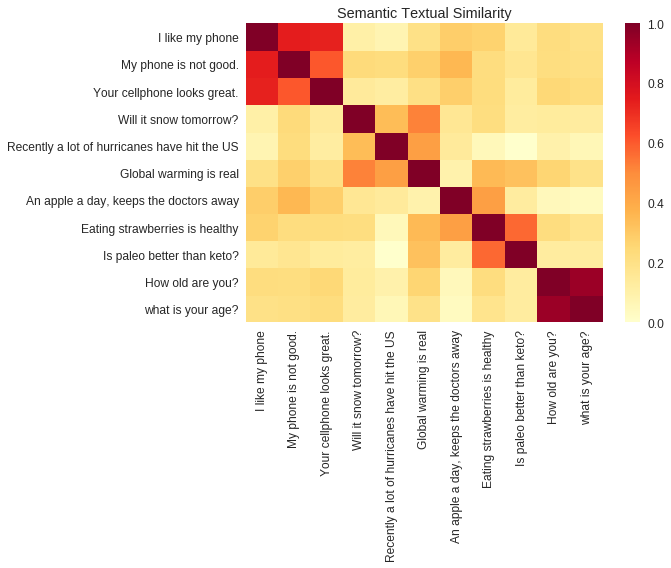

In [0]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  run_and_plot(session, similarity_input_placeholder, messages,
               similarity_message_encodings)